In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import torch
import torchvision
import torchvision.transforms as transforms
import torchvision.utils as vutils
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML
import torch.nn as nn
import torch.optim as optim
import os
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

In [3]:
import sys
sys.path.insert(1, '../')

In [47]:
import numpy as np

import torch

from source.mfa.mfa import MFA
from source.wgangp.wgan_model import WGAN_GP
from source.dcgan.dcgan_model import Discriminator, Generator, DCGAN
from source.ins_score.Inception_Score_function import Inception_Score

In [5]:
device = torch.device("cuda:0" if (torch.cuda.is_available()) else "cpu")

In [6]:
predictor = torchvision.models.inception_v3(pretrained=True).to(device)

In [7]:
transform = transforms.Compose(
    [transforms.Resize(299),
     transforms.ToTensor(),
     transforms.Normalize(mean=[0.485, 0.456, 0.406],
                          std=[0.229, 0.224, 0.225])])

In [8]:
class Generated_images(Dataset):

    def __init__(self, z, generator, transform=None, mode=None):
        self.z = z
        self.generator = generator
        self.transform = transform
        self.mode=mode

    def __len__(self):
        return len(self.z)

    def __getitem__(self, idx):
        from PIL import Image

        with torch.no_grad():
            if self.mode=='DCGAN':
                image = np.transpose(self.generator(self.z[idx].reshape(1,Z_LATENT,1,1)).cpu().numpy().squeeze(),(1,2,0))
            elif self.mode=='WGAN':
                self.generator.eval()
                image = np.transpose(self.generator(self.z[idx].reshape(1,Z_LATENT)).cpu().numpy().squeeze(),(1,2,0))
        
        norm = plt.Normalize()
        image = norm(image)
        
        image = Image.fromarray(np.uint8(255*image))

        if self.transform:
            image = self.transform(image)

        return image

In [9]:
class MFADataset(Dataset):
    def __init__(self, samples,transform=None):
        self.samples = samples
        self.transform = transform

    def __len__(self):
        return len(self.samples)
    

    def __getitem__(self, idx):
        from PIL import Image
        image = np.transpose(self.samples[idx].numpy(),(1,2,0))
        norm = plt.Normalize()
        image = norm(image)
        
        image = Image.fromarray(np.uint8(255*image))

        if self.transform:
            image = self.transform(image)
        
        return image

In [10]:
num_test = 20000

## DCGAN

In [11]:
# Size of z latent vector
Z_LATENT = 100

# Size of generator output (channels)
GENERATOR_PARAMETER = 64

#  Size of discriminator output (channels)
DISCRIMINATOR_PARAMETER = 64

# Path for logs
LOG_PATH = '../../generative-models/notebooks/dcgan_train_process_2'

In [12]:
model = DCGAN(GENERATOR_PARAMETER, DISCRIMINATOR_PARAMETER,Z_LATENT,device)

In [13]:
checkpoint = torch.load(os.path.join(LOG_PATH,'131000_generator.ckpt'))
model.G.load_state_dict(checkpoint)

<All keys matched successfully>

In [14]:
z_DCGAN = torch.randn(num_test, Z_LATENT, 1, 1, device = device)

In [15]:
images_set_DCGAN = Generated_images(z_DCGAN,model.G,transform=transform,mode='DCGAN')

## WGAN_GP

In [22]:
# Size of z latent vector
Z_LATENT= 100

# Path for logs
LOG_PATH = '../../'

In [23]:
wgangp_model = WGAN_GP(3, Z_LATENT).to(device)
wgangp_model.G.load_state_dict(torch.load(os.path.join(LOG_PATH,'wgangp_gen_40.pt')))

<All keys matched successfully>

In [24]:
z_WGAN = torch.randn(num_test, Z_LATENT,device = device)

In [25]:
images_set_WGAN = Generated_images(z_WGAN,wgangp_model.G,transform=transform,mode='WGAN')

## MFA

In [29]:
# Path for logs
LOG_PATH = '../../'

In [30]:
fa_gmm_model = MFA()

In [31]:
fa_gmm_model.load(os.path.join(LOG_PATH,'e1_fa_256_saved_gmm.pkl'))

In [32]:
fa_samples = fa_gmm_model.draw_samples(num_test, False)

In [33]:
fa_samples = torch.Tensor(fa_samples.reshape(num_test,3,64,64))

In [34]:
images_set_MFA = MFADataset(fa_samples,transform=transform)

## Calculate IS score

In [48]:
IS_DCGAN, IS_err_DCGAN = Inception_Score(images_set_DCGAN, predictor, n=10, bs=100)

In [54]:
print('Inception score for DCGAN equals %.3f+/-%.3f' % (IS_DCGAN,IS_err_DCGAN))

Inception score for DCGAN equals 2.330+/-0.032


In [50]:
IS_WGAN, IS_err_WGAN = Inception_Score(images_set_WGAN, predictor, n=10, bs=100)

In [55]:
print('Inception score for WGAN equals %.3f+/-%.3f' % (IS_WGAN,IS_err_WGAN))

Inception score for WGAN equals 2.403+/-0.039


In [52]:
IS_MFA, IS_err_MFA = Inception_Score(images_set_MFA, predictor, n=10, bs=100)

In [56]:
print('Inception score for MFA equals %.3f+/-%.3f' % (IS_MFA,IS_err_MFA))

Inception score for MFA equals 1.871+/-0.015


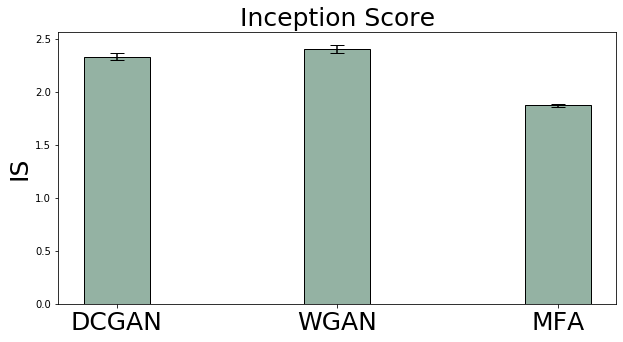

In [68]:
import matplotlib.pyplot as plt

plt.figure(figsize = (10,5))

barWidth = 0.3
 
bars = [IS_DCGAN, IS_WGAN, IS_MFA]
yerr = [IS_err_DCGAN, IS_err_WGAN, IS_err_MFA]

xs = np.arange(len(bars))

plt.bar(xs,height = bars, width = barWidth, color = (0.3,0.5,0.4,0.6), edgecolor = 'black', yerr=yerr, capsize=7)
 
plt.xticks(xs, ['DCGAN', 'WGAN', 'MFA'],fontsize=25)
plt.ylabel('IS',fontsize=25)
plt.title('Inception Score',fontsize=25)
 
# Show graphic
plt.show()
